<h1>The Titanic Dataset : can we predict how survive ?

<h2>1. Imports & first explorations

Let's start with the imports we will need for this work !

In [263]:
import pandas as pd
import numpy as np
import sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute
from sklearn import tree

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer

print('Setup completed')

Setup completed


Then we will make the next ligns to import our data, we will repeat these lines of code to reimport our data everytime we want to test new things on our data.

In [209]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
index_test = test.PassengerId
X_train = train.drop(columns=['Survived'], axis=1)
y_train = train.Survived
print('Data is ready')

Data is ready


In [179]:
X_train.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<h2>2. First model without feature engineering.
<h4>We are only going to consider 'main' features and erase the others, and we wille have our first model.

In [210]:
X_train = X_train.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)
X_train = pd.get_dummies(X_train, drop_first=True)
X_train.head(3)


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True


On doit désormais imputer nos données car il nous en manque, notamment dans la colonne 'Age'. Pour cela on va utiliser les imputers de sklearn.

In [211]:
num_cols=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
imputer=impute.IterativeImputer()
imputer.fit(X_train[num_cols])
imputed=imputer.transform(X_train[num_cols])
X_train.loc[:,num_cols]=imputed


In [182]:
X_train.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True


On peut désormais standardiser nos données, toutefois on ne va pas standardiser nos colonnes factices.

In [212]:
scaler=preprocessing.StandardScaler()
cols= "Pclass,Age,SibSp,Parch,Fare".split(",")

scaler.fit(X_train[cols])
X_train.loc[:,cols] = scaler.transform(X_train[cols]).astype('int64')

<Axes: >

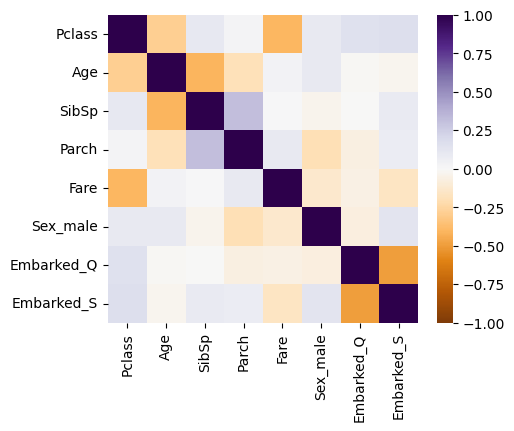

In [197]:
# Calcul de la matrice de corrélation deux à deux
corr_matrix = X_train.corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )

In [198]:
for model in [DummyClassifier, LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, RandomForestClassifier, xgboost.XGBClassifier]:
    cls = model()
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=4)
    s=model_selection.cross_val_score(cls, X_train, y_train, scoring="roc_auc", cv=kfold)
    print(
        f"{model.__name__:22} AUC:"
        f"{s.mean():.3f}    STD:  {s.std():.2f}"
    )

DummyClassifier        AUC:0.500    STD:  0.00
LogisticRegression     AUC:0.853    STD:  0.03
DecisionTreeClassifier AUC:0.838    STD:  0.05
KNeighborsClassifier   AUC:0.825    STD:  0.04
GaussianNB             AUC:0.817    STD:  0.03
SVC                    AUC:0.807    STD:  0.04
RandomForestClassifier AUC:0.854    STD:  0.04
XGBClassifier          AUC:0.849    STD:  0.04


Looking at the results, we want to pursue the idea of a Random Forest Classifier. We are going now to create the model and try to optimize through the values of the hyperparameters, and to explore it we are going to use a Grid Search.

In [186]:
rf=RandomForestClassifier(random_state=4)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

grid = model_selection.GridSearchCV(rf, param_grid=param_grid, cv=kfold)

grid.fit(X_train,y_train)

,estimator,RandomForestC...andom_state=4)
,param_grid,"{'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [199]:
print(grid.best_params_)

{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


In [202]:
def process(df):
    df=df.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])
    df=pd.get_dummies(df, drop_first=True)
    num_cols=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
    df[num_cols] = df[num_cols].astype(float)
    imputed=imputer.transform(df[num_cols])
    df.loc[:,num_cols]=imputed

    cols= "Pclass,Age,SibSp,Parch,Fare".split(",")
    df.loc[:,cols] = scaler.transform(df[cols])

    return df

In [207]:
rf_final = RandomForestClassifier ( max_depth=5,  max_features='log2', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
rf_final.fit(X_train,y_train)
pd.DataFrame(rf_final.predict(X_train),index=train.PassengerId, columns=["Survived"]).value_counts()

Survived
0           578
1           313
Name: count, dtype: int64

In [213]:
rf_final = RandomForestClassifier ( max_depth=5,  max_features='log2', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42)
rf_final.fit(X_train,y_train)

test=process(test)

y_pred=rf_final.predict(test)


pred=pd.DataFrame(y_pred, index=index_test, columns=["Survived"])
#pred.to_csv('titanic_pred.csv')
pred.value_counts()

Survived
0           228
1           190
Name: count, dtype: int64

<h2> 3. Feature Engineering : creation of new variables

I submitted the 'rf_final' model to Kaggle and I received a 0,77 accuracy. It looks like it is a usual score for the dataset, although there is still some new things that I could add to continue to improve the model. One of the leads could be feature engeenering, in other words create new features like Title, or family size. I would also like to try to make a clean sklearn pipeline with the class Pipeline and ColumnTransformer.

In [265]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
data = pd.concat([train,test])
index_test = test.PassengerId
X_train = train.drop(columns=['Survived'], axis=1)
#y_train = train.Survived --> Because we are going to erase a few rows after
print('Data is ready')

Data is ready


<h3>New columns : Title, Family, IsAlone, Cabin ...<h3>

In [234]:
data['Title'] = data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
rare_titles = ['Don','Rev', 'Dr', 'Major', 'Jonkheer', 'Lady', 'Sir', 'the Countess', 'Ms', 'Capt', 'Col', ]
data.Title = data.Title.replace(rare_titles, 'Rare')
data.Title = data.Title.replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare', 'Dona'], dtype=object)

In [236]:
data['Family']=data.Parch+data.SibSp+1
data['IsAlone']=(data.Family==1).astype('int64')

Now the goal is also to extract new informations from the Cabin and maybe the ticket feature !

In [237]:
data['cabin_adv'] = data.Cabin.apply(lambda x: str(x)[0]) #Position of the cabin + have they a cabin ?
data['cabin_nb'] = data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' '))) #Did they have multiple cabins ?


We need to impute the datas now. And I will try to do it with a different method now. I am going to check what features we need to impute in the test dataset and I will try to impute the Age in a better way. For exemple, I am going to try to impute the Age according to the Title of the person. It will be more precise for the Rare or the Master title.

In [ ]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Ok so the problem seems the same, although we have also a Fare missing value but we will fill it with the mean !

In [240]:
for title in data['Title'].unique():
    mask = (data['Title'] == title) & (data['Age'].isna())
    mean_age = data.loc[data['Title'] == title, 'Age'].mean()
    data.loc[mask, 'Age'] = mean_age

We imputed all of the Age missing values !

In [242]:
data.isnull().sum() 

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Title             0
Family            0
IsAlone           0
cabin_adv         0
cabin_nb          0
dtype: int64

In [271]:
data.Fare=data.Fare.fillna(data.Fare.mean())
data.dropna(subset=['Embarked'],inplace = True)
l = X_train.shape[0]
y_train = data.loc[:l-1].Survived
data['norm_fare'] = np.log(data.Fare+1)
data.Pclass=data.Pclass.apply(lambda x: str(x))
data.Pclass.dtype

dtype('O')

We are now going to encode/scale our data according if they are categorical or numerical !

In [ ]:
categorical = ['Pclass', 'Sex', 'Embarked', 'cabin_adv', 'Title']
numerical = ['Age', 'SibSp', 'Parch', 'norm_fare', 'cabin_nb']

dummies = pd.get_dummies(data[categorical], drop_first=True)

all_features = pd.concat([data[numerical], dummies], axis=1)


scaler = StandardScaler()
all_features[numerical] = scaler.fit_transform(all_features[numerical])

In [269]:
X_scaled = all_features.iloc[:l-2] #Because I erased two rows with the missing values of Embarked
X_scaled

,Age,SibSp,Parch,norm_fare,cabin_nb,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,...,cabin_adv_E,cabin_adv_F,cabin_adv_G,cabin_adv_T,cabin_adv_n,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,-0.598126,0.480272,-0.445407,-0.896869,-0.472140,False,True,True,False,True,...,False,False,False,False,True,False,False,True,False,False
1,0.616476,0.480272,-0.445407,1.347099,1.271044,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,-0.294476,-0.479537,-0.445407,-0.815559,-0.472140,False,True,False,False,True,...,False,False,False,False,True,False,True,False,False,False
3,0.388738,0.480272,-0.445407,1.047516,1.271044,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
4,0.388738,-0.479537,-0.445407,-0.801179,-0.472140,False,True,True,False,True,...,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.218563,-0.479537,-0.445407,-0.350094,-0.472140,True,False,True,False,True,...,False,False,False,False,True,False,False,False,False,True
887,-0.825864,-0.479537,-0.445407,0.471789,1.271044,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
888,-0.613671,0.480272,1.864701,0.226384,-0.472140,False,True,False,False,True,...,False,False,False,False,True,False,True,False,False,False
889,-0.294476,-0.479537,-0.445407,0.471789,1.271044,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


<h3>Test of model : baseline without finetuning

In [272]:
#Used as a baseline
gnb = GaussianNB()
cv = cross_val_score(gnb,X_scaled,y_train,cv=10)
print(cv)
print(cv.mean())

[0.71910112 0.71910112 0.71910112 0.7752809  0.75280899 0.75280899
 0.79775281 0.74157303 0.83146067 0.75      ]
0.7558988764044943
